<a href="https://colab.research.google.com/github/snekumar/AD_Prediction/blob/main/2dCNN/2dcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('project')

Mounted at project


In [ ]:
# Importing TensorFlow and Keras modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten,
    GaussianNoise, GlobalAveragePooling2D, Input, MaxPooling2D, Rescaling,
    Resizing, SeparableConv2D)
import tensorflow.keras.layers as layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Importing data processing and visualization modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importing scikit-learn modules
from sklearn.metrics import confusion_matrix

# Importing miscellaneous modules
import random
import time

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
len(gpus)

1

In [ ]:
batch_size = 32
img_height = 220
img_width = 220
seed = 69

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    "/content/project/MyDrive/project/Alzheimer_s Dataset/train",
    subset='training',
    validation_split=0.2,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5125 files belonging to 4 classes.
Using 4100 files for training.


In [ ]:
val_data = tf.keras.utils.image_dataset_from_directory(
     "/content/project/MyDrive/project/Alzheimer_s Dataset/train",
    subset='validation',
    validation_split=0.2,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5125 files belonging to 4 classes.
Using 1025 files for validation.


In [ ]:
class_names = train_data.class_names
num_classes = len(class_names)

print(f'{num_classes} classes: {class_names}')

4 classes: ['AD', 'CN', 'MCI', 'NonDemented']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNEAUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def plot_images(n_rows=3, n_cols=7, data=train_data):
    plt.figure(figsize=(n_cols*2, int(n_rows*1.8)))
    for images, labels in data.take(int((n_rows * n_cols) / batch_size) + 1): # "take" takes random batch
        for i in range(n_rows*n_cols):
            ax = plt.subplot(n_rows, n_cols, i + 1)
            plt.imshow(images[i].numpy().astype("uint16"))
            plt.title(class_names[labels[i]])a
            plt.axis("off")

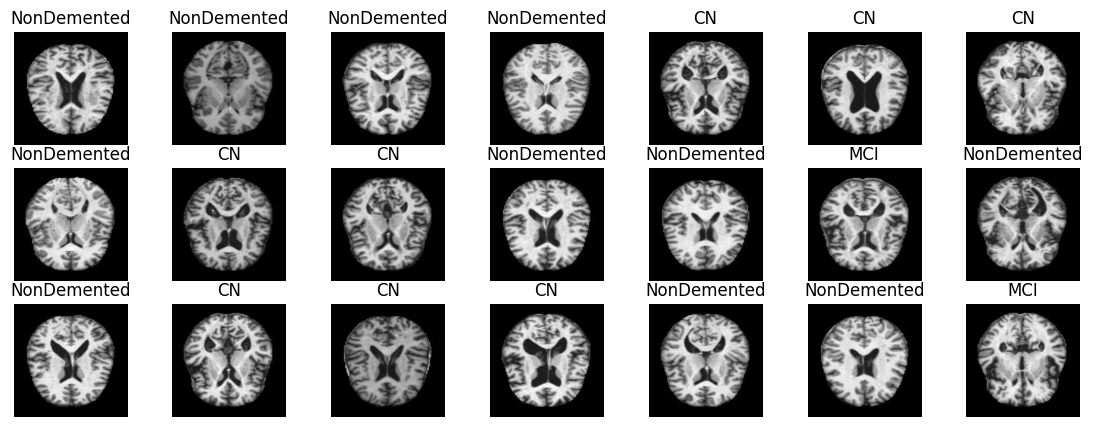

In [ ]:
plot_images()

In [ ]:
for image_batch, labels_batch in train_data:
    image_shape = image_batch.shape
    print(f"Image batch shape: {image_shape}")
    print(f"Label batch shape: {labels_batch.shape}")
    break

Image batch shape: (32, 220, 220, 3)
Label batch shape: (32,)


# Model

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(scale=1./255)

In [ ]:
input_layer = Input(shape=(img_width, img_height, 3))
gaussian_noise = GaussianNoise(0.15)(input_layer)

In [ ]:
branch_1 = normalization_layer(gaussian_noise)

branch_1 = Conv2D(32, (3,3), padding='same', activation="relu")(branch_1)
branch_1 = BatchNormalization()(branch_1)
branch_1 = MaxPooling2D((2, 2))(branch_1)

branch_1 = Conv2D(64, (3,3), padding='same', activation="relu")(branch_1)
branch_1 = BatchNormalization()(branch_1)
branch_1 = MaxPooling2D((2, 2))(branch_1)

branch_1 = Conv2D(128, (3,3), padding='same', activation="relu")(branch_1)
branch_1 = BatchNormalization()(branch_1)
branch_1 = MaxPooling2D((2, 2))(branch_1)

branch_1 = Conv2D(64, (3,3), padding='same', activation="relu")(branch_1)
branch_1 = BatchNormalization()(branch_1)
branch_1 = MaxPooling2D((2, 2))(branch_1)

branch_1 = Flatten()(branch_1)

In [ ]:
output_layers = Dense(256, activation='relu')(branch_1)
output_layers = Dense(128, activation='relu')(output_layers)

output_layers = Dropout(0.5)(output_layers)

output_layers = Dense(num_classes, activation='softmax')(output_layers)

model instance

In [ ]:
model = tf.keras.Model(input_layer, output_layers)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

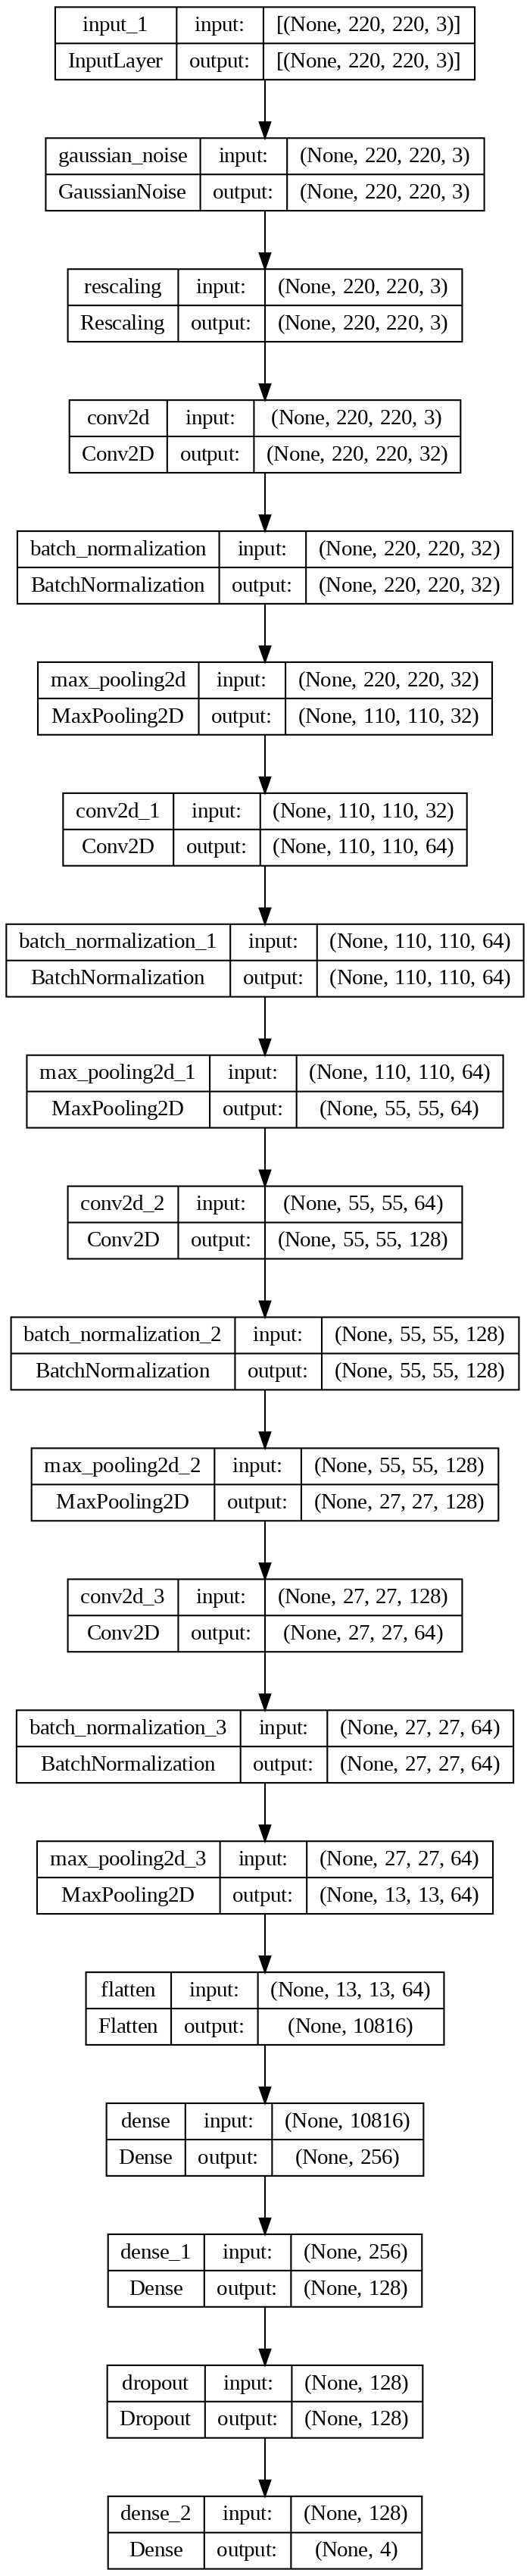

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=150)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 220, 220, 3)]     0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 220, 220, 3)      0         
 se)                                                             
                                                                 
 rescaling (Rescaling)       (None, 220, 220, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0     

1. Early stopping

In [ ]:
early_stopping= EarlyStopping(monitor='val_loss', patience=4,start_from_epoch=3,restore_best_weights=True)

2. ReduceLROnPlateau

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)


Training

In [ ]:
epochs = 40

history = model.fit(
  train_data,
  epochs = epochs,
  validation_data = val_data,
  batch_size = batch_size,
  callbacks = [early_stopping, reduce_lr],
  verbose = 1
)

Epoch 1/40
129/129 [==============================] - 9s 68ms/step - loss: 0.0084 - accuracy: 0.9993 - val_loss: 0.0589 - val_accuracy: 0.9785 - lr: 1.0000e-07
Epoch 2/40
129/129 [==============================] - 9s 69ms/step - loss: 0.0084 - accuracy: 0.9990 - val_loss: 0.0590 - val_accuracy: 0.9785 - lr: 1.0000e-07
Epoch 3/40
129/129 [==============================] - 10s 74ms/step - loss: 0.0080 - accuracy: 0.9990 - val_loss: 0.0590 - val_accuracy: 0.9785 - lr: 1.0000e-07
Epoch 4/40
129/129 [==============================] - 9s 68ms/step - loss: 0.0062 - accuracy: 0.9995 - val_loss: 0.0591 - val_accuracy: 0.9785 - lr: 1.0000e-07
Epoch 5/40
129/129 [==============================] - 9s 69ms/step - loss: 0.0083 - accuracy: 0.9993 - val_loss: 0.0591 - val_accuracy: 0.9785 - lr: 1.0000e-07
Epoch 6/40
129/129 [==============================] - 10s 74ms/step - loss: 0.0092 - accuracy: 0.9990 - val_loss: 0.0590 - val_accuracy: 0.9785 - lr: 1.0000e-07
Epoch 7/40
129/129 [==================

Model training and validation metrics

In [ ]:
# Extract metrics from history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Plot accuracy metrics
ax1.plot(acc, label='Training Accuracy', color='blue', linestyle='solid')
ax1.plot(val_acc, label='Validation Accuracy', color='orange', linestyle='dashed')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Training and Validation Accuracy', fontsize=10)
ax1.grid()

# Plot loss metrics
ax2.plot(loss, label='Training Loss', color='blue', linestyle='solid')
ax2.plot(val_loss, label='Validation Loss', color='orange', linestyle='dashed')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Training and Validation Loss', fontsize=10)
ax2.grid()

# Add legend and title to figure
fig.legend(loc='lower center', ncol=2, fontsize=10)
fig.suptitle('Model Training History', fontsize=16)

# Show the plot


Validation

In [ ]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(val_data)

# Calculate the number of misclassified images
num_misclassified = int((1 - accuracy) * len(val_data) * batch_size)

# Print the results
print(f"Validation loss: {loss:.4f}")
print(f"Validation accuracy: {accuracy:.4f}")
print(f"Number of misclassified images: {num_misclassified} of {len(val_data) * batch_size}")

33/33 [==============================] - 1s 22ms/step - loss: 0.0581 - accuracy: 0.9795
Validation loss: 0.0581
Validation accuracy: 0.9795
Number of misclassified images: 21 of 1056


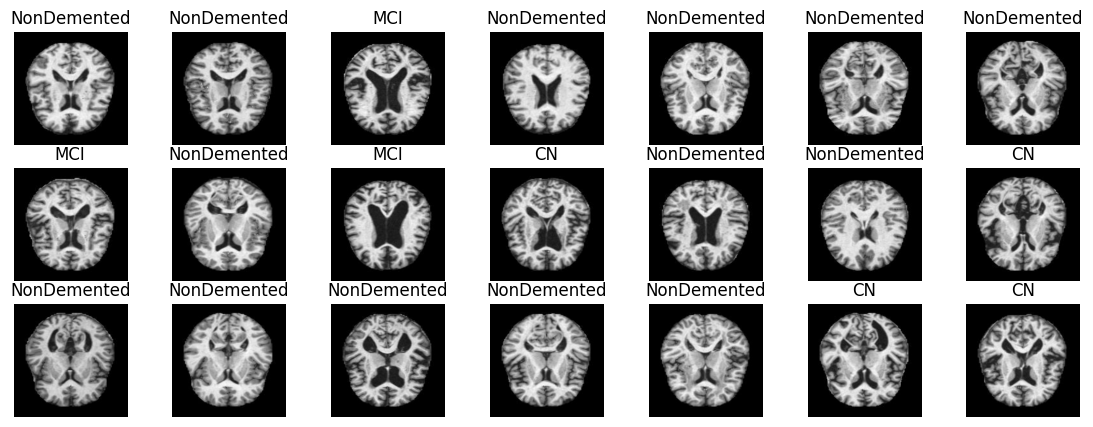

In [ ]:
plot_images(data=val_data)